In [2]:
import pandas as pd
import numpy as np
import sys
from matplotlib import pyplot as plt

from gensim.models import Word2Vec
import tensorflow as tf

In [3]:
class Batch():
    
    def __init__(self, df, batch_size):
        self._initialize(df, batch_size)
    
    def _initialize(self, df, batch_size):
        
        self._batch_size = batch_size
        self.n_batch = len(df) // batch_size
        
        np.random.seed(0)
        idx = np.array(df.index)
        np.random.shuffle(idx)
        self.df = df.loc[idx]
    
    def get_batch(self, i):
    
        batch_size = self._batch_size
        df = self.df
    
        def get_X(sen):
            X = np.zeros([128], dtype=np.int32)-1
            X[:len(sen)] = sen
            return X

        def get_y(label):
            idx = ['pos', 'neg'].index(label)
            y = np.array([0, 0])
            y[idx] = 1
            return y
        
        start, end = i*batch_size, (i+1)*batch_size
        df = df[start:end]
        
        Xs = np.array([get_X(sen) for sen in df['pos']])
        ys = np.array([get_y(label) for label in df['label']])

        return Xs, ys

In [4]:
dropout_rate = 0.2

lookup_table = np.concatenate([
    pd.read_pickle('./data/lookup_table'),
    np.zeros([1, 512])]
)

tf.set_random_seed(0)
np.random.seed(0)

tf.reset_default_graph()
graph = tf.get_default_graph()

X = tf.placeholder(dtype=tf.int32, shape=[None, 128])
y = tf.placeholder(dtype=tf.float32, shape=[None, 2])
table = tf.Variable(lookup_table, dtype=tf.float32)
X_ebd = tf.nn.embedding_lookup(table, X)

lstm_cell_fw = tf.nn.rnn_cell.BasicLSTMCell(num_units=256)
lstm_cell_bw = tf.nn.rnn_cell.BasicLSTMCell(num_units=256)
output, state = tf.nn.bidirectional_dynamic_rnn(
    lstm_cell_fw, lstm_cell_bw, X_ebd, dtype=tf.float32
)
logit = tf.concat(output, axis=1)

conv = tf.reshape(tf.layers.conv1d(logit, 128, 256), [-1, 128])
conv_bn = tf.layers.batch_normalization(conv)
conv_sg = tf.nn.sigmoid(conv_bn)
conv_fin = tf.layers.dropout(conv_sg, dropout_rate)

w = tf.Variable(tf.truncated_normal([128, 2], dtype=tf.float32))
b = tf.Variable(tf.truncated_normal([2], dtype=tf.float32))
fin = tf.nn.softmax(tf.matmul(conv_fin, w)+b)

acc = tf.reduce_mean(tf.cast(
    tf.equal(tf.argmax(fin, axis=1), tf.argmax(y, axis=1)),
    dtype=tf.float32
))
loss = tf.losses.softmax_cross_entropy(y, fin)
learn = tf.train.AdamOptimizer().minimize(loss)

initilizer = tf.global_variables_initializer()

sess = tf.Session(graph=graph)
sess.run(initilizer)

In [5]:
batch_size = 256
df = pd.read_pickle("./data/df")
df = df[df['label'] != 'neu']

batch = Batch(df, batch_size)
n_iter = batch.n_batch

n_epoch = 0
acc_log = []
loss_log = []

In [6]:
for i in range(n_iter):
    train_X, train_y = batch.get_batch(i)
    feed_dict = {X: train_X, y: train_y}
    acc_, loss_, _ = sess.run([acc, loss, learn],
                              feed_dict=feed_dict)
    acc_log.append(acc_)
    loss_log.append(loss_)
    sys.stdout.write("\r% 5d | %5.2f%% | %8.7f | %8.7f"
                     % (n_epoch, (i/n_iter*100), acc_, loss_))
    
    ###
    if i > 200:
        break
    ###
    
n_epoch += 1

    0 |  8.14% | 0.7421875 | 0.5690434

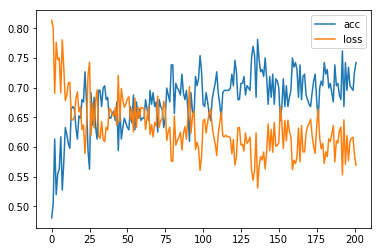

In [7]:
start = 0
plt.plot(acc_log[start:])
plt.plot(loss_log[start:])
plt.legend(['acc', 'loss'])
plt.show()

In [ ]:
saver = tf.train.Saver()
saver.save(sess, "./sess.ckpt")
sess.close()

In [170]:
class TF_Agent():
    
    def __init__(self):
        self._initialize()
        
    def _initialize(self):
        np.random.seed(0)
        
    def feed_train(self, train_X, train_y):
        self.train_X = train_X
        self.train_y = train_y
        
    def set_keys(self, keys):
        self.log_df = pd.DataFrame({key: [] for key in keys})
        log_df = self.log_df
        self.keys = log_df.columns
        self.iter_count = 0

    def set_batch(self, n, feed_dict):

        keys = list(feed_dict.keys())
        
        data_n = len(feed_dict[keys[0]])
        idxs = np.random.choice(range(data_n), n, replace=False)
        
        feed_dict = {key: feed_dict[key][idxs] for key in keys}
        self.feed_dict = feed_dict
    
    def run_session(self, sess):
        
        keys = self.keys
        self.iter_count
        feed_dict = self.feed_dict
        log_df = self.log_df
        
        values = sess.run(eval(",".join(keys)), feed_dict=feed_dict)
        recent_log = pd.Series(values, index=keys, name=iter_count)

        self.log_df = log_df.append([recent_log])
        self.recent_log = recent_log
        self.iter_count += 1
        
    def trace(self, args):
        
        iter_count = self.iter_count
        
        print_ = "\rIter: % 6d" % iter_count
        for arg in args:
             print_ += " | %s: %0.9f" % (
                arg, self.recent_log[arg]
            )

        sys.stdout.write(print_)

총 리뷰 수:	 6569690


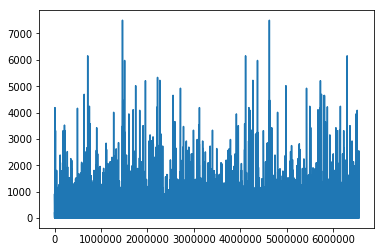

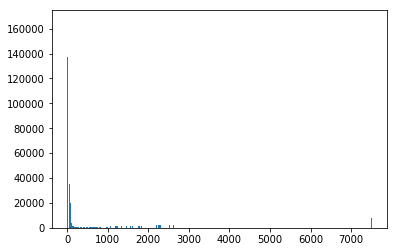

전처리 후 리뷰 수:	 1081159
	0.5 점 리뷰 수:	 14314
	1.0 점 리뷰 수:	 17988
	1.5 점 리뷰 수:	 18393
	2.0 점 리뷰 수:	 51121
	2.5 점 리뷰 수:	 59770
	3.0 점 리뷰 수:	 150555
	3.5 점 리뷰 수:	 173544
	4.0 점 리뷰 수:	 275624
	4.5 점 리뷰 수:	 136232
	5.0 점 리뷰 수:	 183618


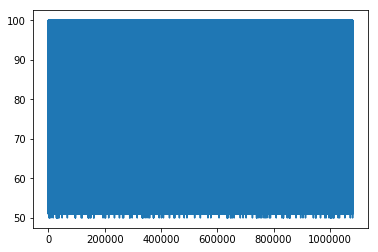

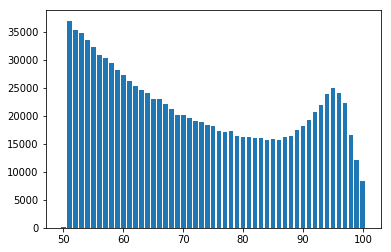

최적 경계선:	 [3.5, 4.5]
경계별 리뷰 수
	부정:	312141
	중립:	449168
	긍정:	319850


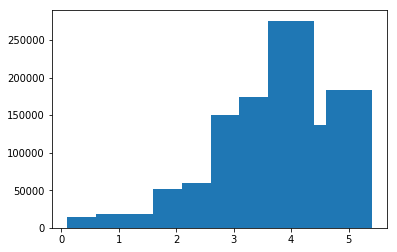

In [3]:
from report import Report

report = Report()
report.present()

In [98]:
set(np.concatenate(df['pos'].reset_index(drop=True))[:, 1])

{'ECD',
 'ECE',
 'ECS',
 'EFA',
 'EFI',
 'EFN',
 'EFO',
 'EFQ',
 'EFR',
 'EPH',
 'EPP',
 'EPT',
 'ETD',
 'ETN',
 'IC',
 'JC',
 'JKC',
 'JKG',
 'JKI',
 'JKM',
 'JKO',
 'JKQ',
 'JKS',
 'JX',
 'MAC',
 'MAG',
 'MDN',
 'MDT',
 'NNB',
 'NNG',
 'NNM',
 'NNP',
 'NP',
 'NR',
 'UN',
 'VA',
 'VCN',
 'VCP',
 'VV',
 'VX',
 'VXA',
 'VXV',
 'XPN',
 'XR',
 'XSA',
 'XSN',
 'XSV'}

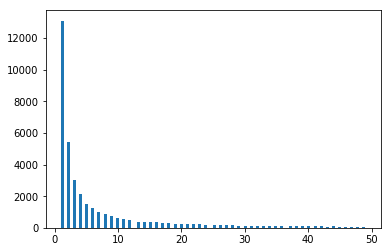

In [97]:
from matplotlib import pyplot as plt


def get_word2freq(se_words):

    words = np.concatenate(se_words.reset_index(drop=True))
    word2freq = {key: 0 for key in set(words)}
    
    for i, word in enumerate(words):
        word2freq[word] += 1
        sys.stdout.write("\r% 5.2f%%"%((i+1)/len(words)*100))
    
    return word2freq


word2freq = get_word2freq(se_words)
l = [word2freq[word] for word in word2freq if word2freq[word] < 100]
plt.hist(l, bins=100)
plt.show()